# Climate Markov Modelling
Predict temperature change with Markov probability model.
Very good at multi-step predictions.

This model has the following assumptions:
 - Past temperatures in the same time of the year change alike.
 - All places change alike.
 - Temperature change is only dependent on the time of the year and the
      previous few temperature.

Global TODO:
 - Add support for hemisphere detection (currently all dataset input should
   be in the same hemisphere).
 - Add warping for location of the station. (Hence it's recommended to use
   only one location for training.).
 - Add support for inexact temperature match.
 - Add time warping.
 - Return the confidence of the prediction.

In [1]:
import pickle
from typing import BinaryIO, Dict, List, Tuple, Union

import gsod
from matplotlib import pyplot as plt
import numpy as np
from numpy.typing import NDArray
from scipy.stats import norm

gsod.enable_svg_graphing()

Now let's build a simple first degree Markov predictor.

In [2]:
class SimpleTemperaturePredict:
    """Predict temperatures with Markov methods."""

    def __init__(self):
        # Format: {(old_temperature, date_from_jan1): [diff, idx_this]}
        # idx_this is for updating average
        self._prab: Dict[Tuple[int, int], List[Union[float, int]]] = {}
        # Approx. a month around
        self._sigma = 10

    def _serialize(self):
        """Serialize data. Responsible for keeping ABI."""
        return {
            "sigma": self._sigma,
            "data": self._prab
        }

    def _deserialize(self, payload: Dict):
        """Deserialize into self."""
        if "sigma" in payload:
            self._sigma = payload["sigma"]
        if "data" in payload:
            self._prab = payload["data"]
            
    def save(self, file: BinaryIO):
        """Save internal dataset."""
        pickle.dump(self._serialize(), file)

    def load(self, file: BinaryIO):
        """Save internal dataset."""
        self._deserialize(pickle.load(file))

    @staticmethod
    def date_to_diff(date: np.datetime64) -> int:
        """Date to count from Jan 1st."""
        time_diff = date - date.astype("datetime64[Y]")
        return time_diff.astype("timedelta64[D]").astype(int)
        
    
    def fit(self, temperature: NDArray[np.floating], date: NDArray[np.datetime64]):
        """Fill the internal dataset.

        `temperature`: An array of temperature data in chronological order.
        `date`: Corresponding dates with the same dimension.
        """
        # Remove the last point because it does not have a next
        for (n, t), d in zip(enumerate(temperature), date[:-1]):
            tmp_diff = temperature[n+1] - t
            old_t = (round(t), self.date_to_diff(d))
            if old_t in self._prab:
                old_idx = self._prab[old_t][1]
                self._prab[old_t][1] += 1
                # Average update
                self._prab[old_t][0] *= old_idx
                self._prab[old_t][0] += tmp_diff
                self._prab[old_t][0] /= old_idx + 1
            else:
                # Initialize
                self._prab[old_t] = [tmp_diff, 1]

    def predict(self, today_temperature: float, date: np.datetime64, sigma: float = -1):
        """Predict a temperature change for the tomorrow.

        `today_temperature`: Temperature on the day before.
        `date`: Date representation of `today_temperature`.
        `sigma`: Gaussian stdev.

        Return: Temperature difference.
        """
        sigma = sigma if sigma >= 0 else self._sigma
        results = []
        weights = []
        for key in self._prab:
            if int(today_temperature) in key:
                # XXX: Find KNN here instead of exact match
                results.append(self._prab[key][0])
                weights.append(norm(self.date_to_diff(date), sigma).pdf(key[1]))
        # TODO: Calculate confidence level
        return np.average(results, weights=weights)

Specification for datasets.

In [3]:
STATION = "722860"
ds = gsod.GsodDataset("runtime/GSOD")
temperatures = ds.read_continuous(stn=STATION, year="????", interpolate=True)["TEMP"]

In [4]:
# Restrict range for LOOCV
load_range = slice(np.datetime64("2019-12-31"))
t = temperatures[load_range]
dates = t.index.to_numpy()
# Train the model
model = SimpleTemperaturePredict()
model.fit(temperature=t, date=dates)
print(model.predict(84.4, np.datetime64("2021-07-27")))

-0.9923808557514856


In [5]:
def next_tmp(model, initial_tmp: float, initial_date: np.datetime64):
    prev = initial_tmp
    date = initial_date
    while True:
        prev += model.predict(prev, date)
        date += 1
        yield prev

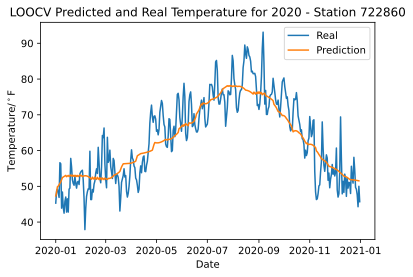

In [6]:
jan1 = np.datetime64("2020-01-01")
count = np.datetime64("2020-12-31") - jan1

t = ds.read_continuous(stn=STATION, year="2020", interpolate=True)["TEMP"]
d = t.index.to_numpy()

plt.plot(d, t, label="Real")

# Predict
gen = next_tmp(model, t[jan1], jan1)
itms = np.fromiter(gen, float, count=count.astype(int))
plt.plot(jan1 + np.arange(count).astype("timedelta64[D]"), itms, label="Prediction")

# Chart data
plt.xlabel("Date")
plt.ylabel("Temperature/${}^\circ$F")
plt.title(f"LOOCV Predicted and Real Temperature for 2020 - Station {STATION}")
plt.legend()

What is the error of this model?

In [7]:
rmse = np.average(((t[1:] - itms) ** 2) ** 0.5)
rmse

4.4664919157102885